# Time Series of YCSD Covid Case Metric

This notebook examines the time series of the York County COVID Cases ostensibly used by YCSD to make decisions about school reopenings.

* YCSD presents there metrics on https://ycsd.yorkcountyschools.org/domain/1313
* VDH represents the this number for the localities on https://www.vdh.virginia.gov/coronavirus/coronavirus/covid-19-in-virginia-locality/ and on https://www.vdh.virginia.gov/coronavirus/key-measures/pandemic-metrics/school-metrics/ under the localities tab
* VDH shares the data at https://data.virginia.gov/Government/VDH-COVID-19-PublicUseDataset-Cases/bre9-aqqr
* I'm sharing This notebook in Github at https://github.com/drf5n/YCSD_covid_metrics and https://github.com/drf5n/YCSD_covid_metrics/blob/master/YorkCountyCovidMetric.ipynb

-- David Forrest 2020-12-04


In [14]:
# %matplotlib widget
import os,sys,io, time, datetime, pathlib
import pandas as pd
#import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt

import bokeh.plotting
import bokeh.io
import bokeh.models
from bokeh.io import output_notebook
bokeh.io.output_notebook()

Loading BokehJS ...

In [15]:
def file_age(filepath):
    return time.time() - os.path.getmtime(filepath)


In [16]:
# get the Virginia COVID Case data from https://data.virginia.gov/Government/VDH-COVID-19-PublicUseDataset-Cases/bre9-aqqr

df_name = "VA_vdh_casedata.csv"

df=pd.read_csv(df_name)
#display(datetime.datetime.now() - pd.to_datetime(df['Report Date'].iloc[-1])   )
#display(datetime.datetime.now() - pd.to_datetime(df['Report Date'].iloc[-1])  > datetime.timedelta(days=1) )

#if 1 or file_age(df_name) > 86400/2:
if not os.path.exists(df_name) or (datetime.datetime.now() - pd.to_datetime(df['Report Date'].iloc[-1])  > datetime.timedelta(days=1)) :
    !wget -O $df_name 'https://data.virginia.gov/api/views/bre9-aqqr/rows.csv?accessType=DOWNLOAD'
    pathlib.Path(df_name).touch()

df=pd.read_csv(df_name)    
if (datetime.datetime.now() - pd.to_datetime(df['Report Date'].iloc[-1])  > datetime.timedelta(days=1)) :
    display(f"{df_name} is still old with {df['Report Date'].iloc[-1]}")

--2021-01-02 10:32:49--  https://data.virginia.gov/api/views/bre9-aqqr/rows.csv?accessType=DOWNLOAD
Resolving data.virginia.gov (data.virginia.gov)... 52.206.140.205, 52.206.140.199, 52.206.68.26
Connecting to data.virginia.gov (data.virginia.gov)|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘VA_vdh_casedata.csv’

VA_vdh_casedata.csv     [   <=>              ]   1.81M  3.30MB/s    in 0.5s    

2021-01-02 10:32:51 (3.30 MB/s) - ‘VA_vdh_casedata.csv’ saved [1898809]



In [17]:

df["date"] = pd.to_datetime(df['Report Date'])

df.tail()

,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,date
38831,01/02/2021,51800,Suffolk,Western Tidewater,4059,236,90,2021-01-02
38832,01/02/2021,51810,Virginia Beach,Virginia Beach,17108,761,152,2021-01-02
38833,01/02/2021,51820,Waynesboro,Central Shenandoah,1233,37,13,2021-01-02
38834,01/02/2021,51830,Williamsburg,Peninsula,360,22,8,2021-01-02
38835,01/02/2021,51840,Winchester,Lord Fairfax,1685,76,14,2021-01-02


In [18]:

df = df.sort_values(by=['Locality', 'VDH Health District', 'date'])
display(df.head())

df['TC_diff']= df.groupby('Locality')['Total Cases'].diff().fillna(0)
df['TC_sum14']= df.groupby('Locality')['Total Cases'].diff(14).fillna(0)

display(df.tail())



,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,date
897,03/17/2020,51001,Accomack,Eastern Shore,0,0,0,2020-03-17
1030,03/18/2020,51001,Accomack,Eastern Shore,0,0,0,2020-03-18
1163,03/19/2020,51001,Accomack,Eastern Shore,0,0,0,2020-03-19
1296,03/20/2020,51001,Accomack,Eastern Shore,1,0,0,2020-03-20
1429,03/21/2020,51001,Accomack,Eastern Shore,1,0,0,2020-03-21


,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,date,TC_diff,TC_sum14
38265,12/29/2020,51199,York,Peninsula,1441,36,11,2020-12-29,44.0,312.0
38398,12/30/2020,51199,York,Peninsula,1452,36,12,2020-12-30,11.0,293.0
38531,12/31/2020,51199,York,Peninsula,1472,36,12,2020-12-31,20.0,291.0
38664,01/01/2021,51199,York,Peninsula,1491,36,13,2021-01-01,19.0,278.0
38797,01/02/2021,51199,York,Peninsula,1493,36,13,2021-01-02,2.0,252.0


In [19]:
# Read VDH population data donwloaded from https://apps.vdh.virginia.gov/HealthStats/stats.htm 
# and https://apps.vdh.virginia.gov/HealthStats/documents/xls/2018%20Pop.xls 

pop_file = '/Users/drf/Downloads/2018 Pop.xls'
if not os.path.exists(pop_file):
    ! wget -O "$pop_name" https://apps.vdh.virginia.gov/HealthStats/documents/xls/2018%20Pop.xls

popxls=pd.read_excel('/Users/drf/Downloads/2018 Pop.xls',header=[3])
popxls['FIPS']=51000+(popxls.loc[:,'Code'].fillna(0)).astype(int)  # eliminate NaNs above?
#display(popxls[popxls['Code']==199]['Population'])
#display(popxls['Locality'].str.match('York County').fillna(False))
display(popxls[popxls['Locality'].str.match('York County').fillna(False)])
display(popxls[popxls['Locality'].str.contains('Virginia Beach').fillna(False)])
#display("City:",popxls[popxls['Locality'].str.contains('City').fillna(False)])



,Code,Region,District,Locality,Population,0,1-4,5-9,10-14,15-17,...,20-24.1,25-34,35-44,45-54,55-64,65-74,75-84,85+,0,FIPS
126,199.0,5.0,21.0,York County ...,67846.0,640.0,3151.0,4480.0,4823.0,3062.0,...,4240.0,7876.0,8869.0,8805.0,9284.0,6311.0,3428.0,1218.0,640.0,51199


,Code,Region,District,Locality,Population,0,1-4,5-9,10-14,15-17,...,20-24.1,25-34,35-44,45-54,55-64,65-74,75-84,85+,0,FIPS
124,810.0,5.0,20.0,Virginia Beach City ...,450189.0,5609.0,22638.0,27497.0,27714.0,16115.0,...,31409.0,74440.0,59481.0,55457.0,55664.0,37719.0,18653.0,7632.0,5609.0,51810


In [20]:
# subset for York and normalize per capita
loi='York'

VDH_pop = int(popxls[popxls['Locality'].str.match('York').fillna(False)]['Population'])
display("VDH_pop: ",VDH_pop)


dfy = df[df['Locality']=='York'].copy()
dfy['per100k_14daysum']=dfy['TC_sum14']*100000/68280  
dfy['per100k_14daysum']=dfy['TC_sum14']*100000/VDH_pop



# for VB:

if 0:
    loi='Virginia Beach'

    dfy = df[df['Locality']=='Virginia Beach'].copy()
    dfy['per100k_14daysum']=dfy['TC_sum14']*100000/450189  


'VDH_pop: '

67846

In [21]:
dfy.tail(30)

,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,date,TC_diff,TC_sum14,per100k_14daysum
34940,12/04/2020,51199,York,Peninsula,968,28,9,2020-12-04,11.0,162.0,238.776052
35073,12/05/2020,51199,York,Peninsula,975,31,9,2020-12-05,7.0,158.0,232.880347
35206,12/06/2020,51199,York,Peninsula,992,31,9,2020-12-06,17.0,167.0,246.145683
35339,12/07/2020,51199,York,Peninsula,1007,31,9,2020-12-07,15.0,159.0,234.354273
35472,12/08/2020,51199,York,Peninsula,1012,31,9,2020-12-08,5.0,153.0,225.510715
35605,12/09/2020,51199,York,Peninsula,1023,31,9,2020-12-09,11.0,156.0,229.932494
35738,12/10/2020,51199,York,Peninsula,1038,32,9,2020-12-10,15.0,163.0,240.249978
35871,12/11/2020,51199,York,Peninsula,1046,32,9,2020-12-11,8.0,169.0,249.093535
36004,12/12/2020,51199,York,Peninsula,1069,32,9,2020-12-12,23.0,180.0,265.306724
36137,12/13/2020,51199,York,Peninsula,1089,32,9,2020-12-13,20.0,181.0,266.780650


<AxesSubplot:title={'center':'York County Number of new cases per 100,000 persons \nwithin the last 14 days'}, xlabel='date'>

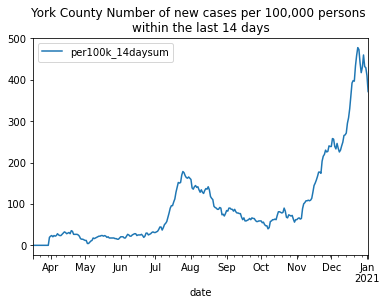

In [22]:
ph = dfy.plot(y='per100k_14daysum',x='date',title="York County Number of new cases per 100,000 persons \nwithin the last 14 days")

ph

<AxesSubplot:title={'center':'York County Cases, 14 day sum, per 100K'}, xlabel='date'>

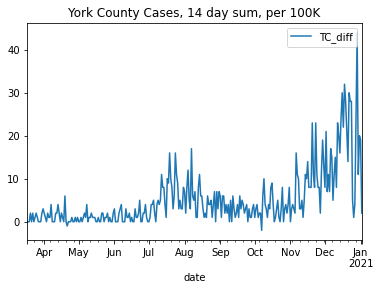

In [23]:
ph = dfy.plot(y='TC_diff',x='date',title="York County Cases, 14 day sum, per 100K")
ph

In [24]:
TOOLTIPS = [
 #   ("index", "$index"),
 #   ("date:", "$x{%F %T}"),
    ("date:", "@date{%F}"),
    ("cases/14d/100k:","@per100k_14daysum"),
 #   ("(x,y)", "($x, $y)"),
]

vmax = (int(dfy['per100k_14daysum'].max() / 40 )+2)*40 # 

per100k_14daysum=bokeh.plotting.figure( tooltips=TOOLTIPS, x_axis_type='datetime')
p=bokeh.plotting.figure( x_axis_type='datetime',y_range=(0,vmax),
#                        tooltips=TOOLTIPS,formatters={"$x": "datetime"},
                        title="{} Number of new cases per 100,000 persons within the last 14 days".format(loi))

    
hth = bokeh.models.HoverTool(tooltips=TOOLTIPS,
                             formatters={"$x": "datetime",
                                        "@date": "datetime"
                                        },
                             mode='vline',
                            )

print(hth)
print(hth.formatters)
p.add_tools(hth)
#hover = p.select(dict(type=bokeh.models.HoverTool))


#hover(tooltips=TOOLTIPS,
#)

p.add_layout(bokeh.models.BoxAnnotation(bottom=0,top=5, fill_alpha=0.4, fill_color='teal'))
p.add_layout(bokeh.models.BoxAnnotation(bottom=5,top=20, fill_alpha=0.4, fill_color='lightgreen'))
p.add_layout(bokeh.models.BoxAnnotation(bottom=20,top=50, fill_alpha=0.4, fill_color='yellow'))
p.add_layout(bokeh.models.BoxAnnotation(bottom=50,top=200, fill_alpha=0.4, fill_color='orange'))
p.add_layout(bokeh.models.BoxAnnotation(bottom=200, fill_alpha=0.4, fill_color='red'))



#p.line(dfy['date'],dfy['per100k_14daysum'])
p.line(x='date', y='per100k_14daysum',source=dfy)
#p.title()

#?p.line

HoverTool(id='1672', ...)
{'$x': 'datetime', '@date': 'datetime'}


GlyphRenderer(id='1683', ...)

In [25]:
bokeh.plotting.show(p)

In [13]:
bokeh.plotting.output_file('docs/YorkCountyCovidMetric_plot.html', mode='inline')
bokeh.plotting.save(p)

# needs geckodriver  -- have it in conda env py3plot
bokeh.io.export_png(p, filename="docs/YorkCountyCovidMetric_plot.png")



'/Users/drf/2020/Home/School/YCSD_covid_metrics/docs/YorkCountyCovidMetric_plot.png'